In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(42)

from collections import Counter

import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import SnowballStemmer, WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yt248\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yt248\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Preprocessing

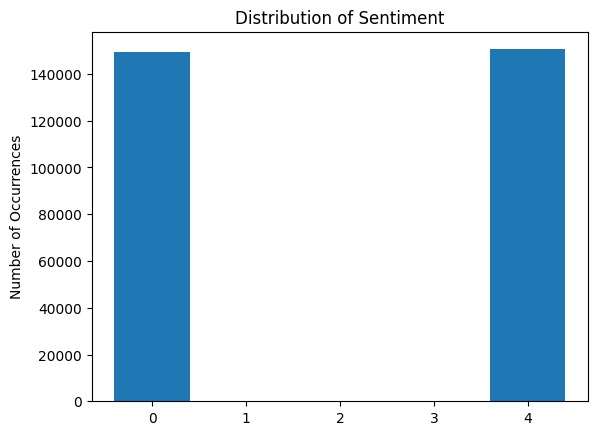

In [2]:
df = pd.read_csv('training.300000.processed.noemoticon.csv')

# drop unused columns
df = df.drop(['id', 'date', 'query', 'username'], axis=1)

# get classes distribution diagram
unique, counts = np.unique(df['sentiment'], return_counts=True)

plt.bar(unique, counts)
plt.title('Distribution of Sentiment')
plt.ylabel('Number of Occurrences')

plt.show()

### Mapping target to numeric

In [3]:
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [5]:
from textblob import Word

# print(df.text)
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# @\S+:           any word that starts with @, refers to a user
# https?:\S+:     any URL that starts with http:// or https://
# [^A-Za-z0-9]+   punctuation marks or special characters
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

def preprocess(text):
    text = str(text).lower()

    tokens = []

    # replace words with repeated chars
    rx = re.compile(r'([^\W\d_])\1{2,}')
    text = re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), text)

    # Replace reqular expression with ' '
    text = re.sub(text_cleaning_re, ' ', text).strip()
    
    for token in text.split():
        if token not in stopwordlist:
            if len(token)>1:
                token = stemmer.stem(token)
                token = lemmatizer.lemmatize(token)
                tokens.append(token)    

    # token_counts = Counter(tokens)
    # min_occurrences = 2
    # tokens = [token for token in tokens if token_counts[token] >= min_occurrences]

    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

#df['text'].to_csv('output_file.csv', index=False)

In [6]:
def find_longest_word():
    longest_word = ''
    for sentence in df['text']:
        for word in sentence.split():
            if len(word) > len(longest_word):
                longest_word = word
    length = len(longest_word)
    return longest_word, length

# Find the longest word in the 'text' column of the dataframe
longest_word, MAX_LENGTH= find_longest_word()
print('Longest word:', str(MAX_LENGTH))


Longest word: 80


In [7]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(df['text'], df['sentiment'], train_size=0.9, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9, random_state=42)

print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (243000,)
X_valid.shape: (27000,)
X_test.shape : (30000,)


### Word Embedding

In [8]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# List of words
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=2,
                 sg=0)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 28056


### Tokenization

In [9]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")

# tokenizer only fit on X_train to avoid information leak
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary Size :", vocab_size)

Vocabulary Size : 76824


### Padding

In [10]:
from keras.utils import pad_sequences

# Padding to length of longest word
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LENGTH)
X_valid = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen = MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LENGTH)

print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (243000, 80)
X_valid.shape: (27000, 80)
X_test.shape : (30000, 80)


In [11]:
embedding_matrix = np.zeros((vocab_size, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        # initial weight of the embedding layer
        embedding_matrix[token] = word2vec_model.wv[word]

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (76824, 100)


## LSTM

In [12]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'    #run on GPU 0

def build_model(hp):
    model = Sequential()

    model.add(layers.Embedding(input_dim=vocab_size,
                               output_dim=Embedding_dimensions,
                               weights=[embedding_matrix],
                               input_length=MAX_LENGTH,
                               trainable=True))       # Do not freeze the weight of embedding layer
    model.add(layers.LSTM(units=hp.Choice('lstm_units', values=[128, 256])))
    model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.5, 0.8])))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
    return model

with tf.device('/GPU:0'):
    stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0)

    tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=1)
    tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=512, callbacks=[stop_early])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
    print(f"Best hyperparameters: {best_hyperparameters.values}")


Trial 10 Complete [00h 07m 05s]
val_accuracy: 0.7923703789710999

Best val_accuracy So Far: 0.7959259152412415
Total elapsed time: 01h 09m 33s
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001}


In [13]:
y_pred = best_model.predict(X_test)

938/938 [==============================] - 20s 21ms/step


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.where(y_pred>=0.5, 1, 0)
confusion_matrix(y_pred, y_test)

array([[11945,  3054],
       [ 2944, 12057]], dtype=int64)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     14889
           1       0.80      0.80      0.80     15111

    accuracy                           0.80     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.80      0.80      0.80     30000



In [16]:
score = best_model.evaluate(X_train, y_train)
print("Training Loss:", score[0])
print("Training Accuracy:", score[1])

7594/7594 [==============================] - 152s 20ms/step - loss: 0.3620 - accuracy: 0.8406
Training Loss: 0.3620239496231079
Training Accuracy: 0.8405596613883972
